# Kaggle Springleaf competition

Beating the benchmark @ Kaggle Springleaf

Basis code provided by Abhishek Thakur

Further edits made by Wendell Kuling

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
from datetime import datetime

from sklearn import preprocessing, linear_model
%matplotlib inline

Reading the data in the Pandas Dataframe

In [2]:
train = pd.read_csv('~/ipython/Kaggle_springleaf/Input/train.csv')
test = pd.read_csv('~/ipython/Kaggle_springleaf/Input/test.csv')

/Users/wendellkuling/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/wendellkuling/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (8,9,10,11,12,43,157,167,177,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


The error messages can be ignored, they also appear when specifying the data type

# 1. Data exploration

Quick exploration of the data. Ommitted here for readability.

In [3]:
# train.head(5).T

In [4]:
# train.info()

In [5]:
# train.describe()

# 2. Data preprocessing

## 2.1 Splitting off the target and the ID column

First, store the target variable in a Pandas series y and stripping the ID and target from the feature dataframes

In [6]:
y = train.target.values
train = train.drop(['ID', 'target'], axis=1)
test = test.drop('ID', axis=1)

A first important decision is how to deal with the missing values. Sometimes, the missing values are 'NAs', sometimes they might be '-1' or strings containing '99'. However, a lesson learned is that an attempt to make this consistent up-front, shows a drop in performance.

## 2.2 Dealing with missing values

One of the tricks, is to first count the number of NAs and '99s' (outliers) per row.

In [7]:
# Add a row wise count of NA’s 

train['NumbNAs'] = train.apply(lambda x : x.isnull().sum(), axis = 1)
test['NumbNAs'] = train.apply(lambda x : x.isnull().sum(), axis = 1)

In [8]:
# and row wise count of outliers (those 999…’s). 

train['Numb99s'] = train.apply(lambda x : x.astype(str).str.contains('99').sum(), axis = 1)
test['Numb99s'] = test.apply(lambda x : x.astype(str).str.contains('99').sum(), axis = 1)

In [9]:
# and row-wise count of -1's

train['Numb-1s'] = train.apply(lambda x : x.astype(str).str.endswith('-1').sum(), axis = 1)
test['Numb-1s'] = test.apply(lambda x : x.astype(str).str.endswith('-1').sum(), axis = 1)

Although even only columns with NA vs. 'False' might imply information, it turns out that just dropping these low cardinality columns gives the best results.

In [10]:
train = train.dropna(axis=1, thresh=2000)
test = test.dropna(axis=1, thresh=2000)

In [11]:
train = train.fillna(-1)
test = test.fillna(-1)

## 2.3 Processing time-related variables: right format and distances between them

In [12]:
# Helper function to process some of the day observations
def timetodaysago(timeobs):
    try:
        d0 = datetime.strptime(timeobs[:7], '%d%b%y')
        d1 = datetime.strptime('01SEP15', '%d%b%y')
        delta = d1 - d0
        return delta.days
    except:
        return timeobs

In [13]:
def isdate(seriestocheck):
    p = re.compile(r'\w{7}:\d{2}:\d{2}:\d{2}') # regex for our datetime format
    for check in seriestocheck:
        if p.match(str(check)):
            return True

First, converting the time stamps to a useful number

In [14]:
datecolumns = []
for f in train.columns:
    top_values = pd.Series(list(train[f].value_counts().keys()))[:10]
    if isdate(top_values):
        # print "Variable: " + f + " is of type date. Converting."
        datecolumns.append(f)
        train[f]=train[f].map(timetodaysago)
        train[f]=train[f].astype('float64')
        test[f]=test[f].map(timetodaysago)
        test[f]=test[f].astype('float64')

Second, calculating the distances between the time stamps

In [15]:
import itertools

for pair in itertools.combinations(datecolumns, 2):
    # print "Adding distance between ", pair
    train[pair[0]+pair[1]] = train[pair[0]] - train[pair[1]]
    test[pair[0]+pair[1]] = test[pair[0]] - test[pair[1]]

## 2.4 Dealing with location-based features

Zip code var 241, 212 (+ID?), 274, 237

Although it seemed logical to me to drop the high-cardinality variables like zip-code, as I expected that an algorithm treating this as a numerical variable would be confused as to the predictive value, from the Kaggle posts it seemed that variable 212 (zip+ID) turns out to have quite an important predictive value.

Way to handle them: 
* Keeping the values in 274, 237 (they will be label-encoded below)
* Adding the mean of the target variable for both 274 and 237 (clustering)
* Dropping 241
* Keep in 212 as a numerical variable

In [16]:
temp = train[['VAR_0274', 'VAR_0237']]
temp['target'] = y

# Putting np.nan back in to facilitate the working of groupby (calculating mean)
temp = temp.applymap(lambda x: np.nan if x == -1 else x)

tempmean_237 = temp.groupby(['VAR_0237']).mean()
searchmean_237 = tempmean_237['target'].to_dict()

tempmean_274 = temp.groupby(['VAR_0274']).mean()
searchmean_274 = tempmean_274['target'].to_dict()

train['at_237'] = train['VAR_0237'].map(lambda x: searchmean_237[x] if (x in searchmean_237) else -1)
test['at_237'] = test['VAR_0237'].map(lambda x: searchmean_237[x] if (x in searchmean_237) else -1)

train['at_274'] = train['VAR_0274'].map(lambda x: searchmean_274[x] if (x in searchmean_274) else -1)
test['at_274'] = test['VAR_0274'].map(lambda x: searchmean_274[x] if (x in searchmean_274) else -1)


/Users/wendellkuling/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Dropping the 241 variable of the zip-code now. Note that the description of the location (2741 and 237) will be label-encoded below.

In [17]:
train.drop(['VAR_0241'], axis = 1, inplace = True)
test.drop(['VAR_0241'], axis = 1, inplace = True)

## 2.5 Dealing with age-related features

From https://www.kaggle.com/darraghdog/springleaf-marketing-response/grouping-numerics-springleaf
We know that VAR_0254, VAR_0255 and VAR_0198 are likely to be age features

Creating three columns: one with the best estimate for age, one with avg target score per age-category, 
* one with avg stdev of target per age-category 
* dropped the stdev one after experimentation

In [18]:
temp = train[['VAR_0254', 'VAR_0255', 'VAR_0198']]
temp = temp.applymap(lambda x: np.nan if x == -1 else x)
temp['age'] = temp.min(axis='columns')
temp['age'] = temp['age'].astype(np.float64)
temp.drop(['VAR_0254', 'VAR_0255', 'VAR_0198'], axis = 1, inplace = True)

temp['target'] = y

tempmean = temp.groupby(['age']).mean()
searchmean = tempmean['target'].to_dict()

# tempstd = temp.groupby(['age']).std()
# searchstd = tempstd['target'].to_dict()

temp['at_age'] = temp['age'].map(lambda x: searchmean[x] if (not pd.isnull(x)) else -1)
# temp['st_age'] = temp['age'].map(lambda x: searchstd[x] if (not pd.isnull(x)) else -1)

train['age'] = temp['age']
train['at_age'] = temp['at_age']
# train['st_age'] = temp['st_age']


temp = test[['VAR_0254', 'VAR_0255', 'VAR_0198']]
temp = temp.applymap(lambda x: np.nan if x == -1 else x)
temp['age'] = temp.min(axis='columns')
temp['age'] = temp['age'].astype(np.float64)
temp['at_age'] = temp['age'].map(lambda x: searchmean[x] if (x in searchmean) else -1)
# temp['st_age'] = temp['age'].map(lambda x: searchstd[x] if (x in searchstd) else -1)

test['age'] = temp['age']
test['at_age'] = temp['at_age']
# test['st_age'] = temp['st_age']

In [19]:
train.drop(['VAR_0254', 'VAR_0255', 'VAR_0198'], axis = 1, inplace = True)
test.drop(['VAR_0254', 'VAR_0255', 'VAR_0198'], axis = 1, inplace = True)

## 2.6 Dealing with other categorical features

I've struggled a lot with this part... Options considered were:
* One-hot encoding all non-value types using pd.get_dummies (Cardinality <= 60 and at least 30 observations)
* Hashing trick (for LR)

However, just using Labelencoder turns out to work best in dealing with these variables when using XGBoost as classifier. The fact that XGBoost works on the best split of instances, can also be concluded by looking at the documentation from XGBoost on http://xgboost.readthedocs.org/en/latest/model.html#learn-the-tree-structure.

So, although one-hot encoding would allow in theory for more relationships between the variables, it also makes the dataset more 'noisy'. This 'noise' effect proved to be much stronger than I expected initially. 

In [20]:
for f in train.columns:
    if train[f].dtype=='object': 
        # print f
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))                    

# 2.7 Clustering binary variables

This section clusters the binary variables, as suggested by Mike Kim in https://www.kaggle.com/c/springleaf-marketing-response/forums/t/17081/solution-sharing. Unfortunately, the Sklearn version doesn't manage to cluster the features in memory using T-SNE (>50 GB). Therefore, switching to DBSCAN here.

In [21]:
temptrain = pd.DataFrame()
temptest = pd.DataFrame()
lbl = preprocessing.LabelEncoder()

for f in train.columns:
    t = train[f].value_counts()
    if (len(t) == 2):
        # print f, " is binary... adding to DataFrame to cluster"
        lbl.fit(list(train[f].values) + list(test[f].values)) # trick to convert to 0/1 always
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))                    
        temptrain[f] = train[f]
        temptest[f] = test[f]

In [22]:
from sklearn.cluster import DBSCAN

temptrain = np.array(temptrain)
temptest = np.array(temptest)
temp = np.concatenate((temptrain, temptest), axis=0)

db = DBSCAN(eps=0.3, min_samples=500).fit(temp) # I want the clusters to be of a reasonable size
labels = db.labels_

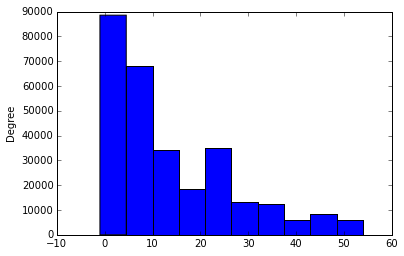

In [23]:
pd.Series(labels).plot(kind='hist')

In [24]:
print max(labels)

54


So, there are 54 clusters found in the binary data. Adding those to the original dataframes.

In [25]:
train['cluster']=labels[:len(train)]

In [26]:
test['cluster']=labels[len(train):]

And that concludes the preprocessing

# 3. Building the prediction model

In [27]:
X = np.array(train)
X_test = np.array(test)

In [28]:
import pickle

with open('X.pickle', 'wb') as handle:
    pickle.dump(X, handle)

with open('X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle)

In [29]:
dtrain = xgb.DMatrix(X, label=y, missing = np.nan)

Setting the parameters for training

In [30]:
param = {"objective": "binary:logistic", "eta": 0.01, "max_depth": 17, "min_child_weight": 1, 
         "subsample": 0.8, "colsample_bytree": 0.7, "eval_metric":"auc"} 

num_rounds = 5000

In [31]:
clf = xgb.train(param, dtrain, num_rounds)

Saving the model for future use

In [32]:
clf.save_model('0011710807.model')

Now, making the predictions

In [33]:
dtest = xgb.DMatrix(X_test, missing = np.nan)
preds = clf.predict(dtest)
print preds[:10]

[ 0.20149408  0.18852733  0.04277033  0.06356515  0.86489332  0.01058526
  0.00275917  0.00316912  0.03029456  0.00159592]


#### Sidenote (lesson learned)

I used to train through the Scikit-Learn Wrapper, but this had two important disadvantages:
* It didn't allow me to set all the parameters (like num-rounds)
* It didn't allow me to get feature importance (needed for the ensemble trick further down)

```
X = np.array(train)
X_test = np.array(test)
clf = xgb.XGBClassifier(n_estimators=5000, nthread=-1, max_depth=17, 
                        learning_rate=0.01, silent=False, subsample=0.8, colsample_bytree=0.7)

# Starting the fitting of the model

clf.fit(X, y, eval_metric = 'auc', verbose = True)
```

Writing the submission file

In [34]:
sample = pd.read_csv('~/ipython/Kaggle_springleaf/Input/sample_submission.csv')
sample.target = preds
sample.to_csv('20151122_fully_preprocessed_XGB_0011710807.csv', index=False)

What does the submission look like now...

<img src="../files/Screenshot.png">

# 4 Studying feature importance

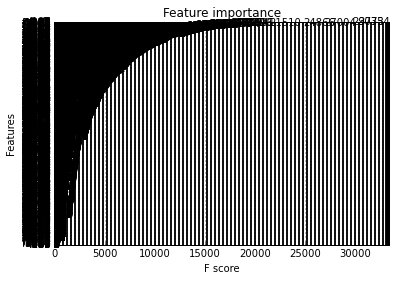

In [35]:
xgb.plot_importance(clf)

In [36]:
importance = clf.get_fscore()

In [37]:
df = pd.DataFrame(zip(importance.keys(),importance.values()), columns = ['feature', 'fscore'])
df.sort('fscore', ascending=False, inplace=True)

In [38]:
df['fscore'] = df['fscore'] / df['fscore'].sum()

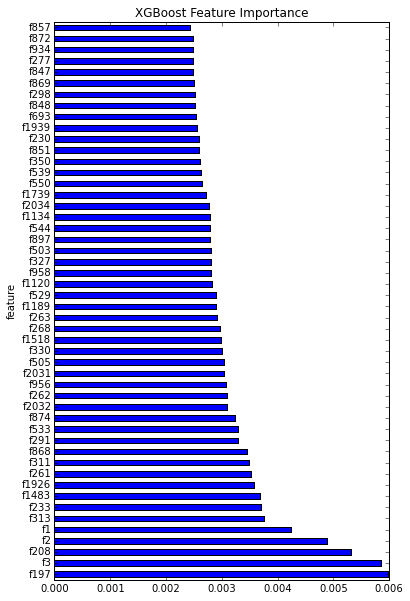

In [39]:
import matplotlib.pyplot as plt
df[:50].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10),
             title='XGBoost Feature Importance')

# 5 Ensemble method resampled from feature importance + LR

First, making sub-sets of X_test and X using every 5th importance feature

In [40]:
selectfeat=[[] for _ in range(5)]
for i in range(len(importance)):
    toadd = df.iat[i,0]
    toadd = toadd[1:] #stripping the 'f' from the string
    toadd = int(toadd)
    selectfeat[i % 5].append(toadd)

In [41]:
Sub_X_train = [[] for _ in range(5)]
Sub_X_test = [[] for _ in range(5)]
for i in range(5):
    Sub_X_train[i] = X[:, selectfeat[i]]
    Sub_X_test[i] = X_test[:, selectfeat[i]]

Second, building models per selected sub-set

In [42]:
param = {"objective": "binary:logistic", "eta": 0.01, "max_depth": 17, "min_child_weight": 1, 
         "subsample": 0.8, "colsample_bytree": 0.7,  
         "eval_metric":"auc"} 
num_rounds = 5000

In [43]:
print "Start pre-processing data for ensemble method"

for i in range(5):
    
    print "Starting training of ", i+1, "/5 model"
    dtrain = xgb.DMatrix(Sub_X_train[i], label=y, missing = np.nan)
    clf = xgb.train(param, dtrain, num_rounds)
    
    print "Finished training, saving the model"
    savename = 'sub_model_' + str(i)
    clf.save_model(savename + '.model')
    
    print "Starting scoring now... first for the test set"
    dtest = xgb.DMatrix(Sub_X_test[i], missing = np.nan)
    preds = clf.predict(dtest)
    # print preds[:10]

    print "Writing sub-submission file for test-set"
    sample = pd.read_csv('~/ipython/Kaggle_springleaf/Input/sample_submission.csv')
    sample.target = preds
    sample.to_csv(savename + '_test.csv', index=False)

    print "Starting scoring now... second for the train set (for training ensemble)"
    dtest = xgb.DMatrix(Sub_X_train[i], missing = np.nan)
    preds = clf.predict(dtest)
    # print preds[:10]
    
    print "Writing sub-submission file for train-set"
    sample = pd.Series(preds)
    sample.to_csv(savename + '_train.csv', index=False)

    print "--- Finished writing sub-submission file ---"
    print

Start pre-processing data for ensemble method
Starting training of  1 /5 model
Finished training, saving the model
Starting scoring now... first for the test set
Writing sub-submission file for test-set
Starting scoring now... second for the train set (for training ensemble)
Writing sub-submission file for train-set
--- Finished writing sub-submission file ---

Starting training of  2 /5 model
Finished training, saving the model
Starting scoring now... first for the test set
Writing sub-submission file for test-set
Starting scoring now... second for the train set (for training ensemble)
Writing sub-submission file for train-set
--- Finished writing sub-submission file ---

Starting training of  3 /5 model
Finished training, saving the model
Starting scoring now... first for the test set
Writing sub-submission file for test-set
Starting scoring now... second for the train set (for training ensemble)
Writing sub-submission file for train-set
--- Finished writing sub-submission file ---



## LR ensemble method

Building a LR model on these scores

In [44]:
df_scores = pd.DataFrame([])

for i in range(5):
    loadname = 'sub_model_' + str(i)
    scoreset = pd.read_csv(loadname + '_train.csv', header=None)
    df_scores[loadname] = scoreset[0]

In [45]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [46]:
X = np.array(df_scores)
model.fit(X, y)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


In [47]:
# make predictions
expected = y
predicted = model.predict(X)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    111458
          1       1.00      1.00      1.00     33773

avg / total       1.00      1.00      1.00    145231

[[111458      0]
 [     0  33773]]


In [48]:
# Study coefficients
print model.coef_

[[ 3.67858611  3.67806815  3.6797211   3.68293876  3.67657941]]


Surpising to see that the models hardly differ from eachother... XGBoost tree (model 0) doesn't seem to get a different weight from the LR

Now, using the LR model to predict the scores for the final submission

In [49]:
df_scores = pd.read_csv('~/ipython/Kaggle_springleaf/Input/sample_submission.csv')

for i in range(5):
    loadname = 'sub_model_' + str(i)
    scoreset = pd.read_csv(loadname + '_test.csv')
    df_scores[loadname] = scoreset['target']

df_scores['target'] = model.predict_proba(np.array(df_scores.loc[:,'sub_model_0':'sub_model_4']))[:,1]

In [50]:
df_scores.head(5)

,ID,target,sub_model_0,sub_model_1,sub_model_2,sub_model_3,sub_model_4
0,1,0.004073,0.152743,0.088854,0.217017,0.199954,0.313686
1,3,0.011421,0.155306,0.128429,0.380673,0.239579,0.350517
2,6,0.000498,0.116180,0.044023,0.157233,0.034223,0.048171
3,9,0.000430,0.142404,0.098406,0.009266,0.094508,0.015489
4,10,0.997921,0.813419,0.885503,0.683390,0.953170,0.809435


Writing the submission file

In [51]:
sample = pd.read_csv('~/ipython/Kaggle_springleaf/Input/sample_submission.csv')
sample.target = df_scores['target']
sample.to_csv('20151122_LR_ensemble_model.csv', index=False)

## Trying Adaboost as ensemble method

In [52]:
from sklearn.ensemble import AdaBoostClassifier

In [53]:
df_scores = pd.DataFrame([])

for i in range(5):
    loadname = 'sub_model_' + str(i)
    scoreset = pd.read_csv(loadname + '_train.csv', header=None)
    df_scores[loadname] = scoreset[0]

In [54]:
model = AdaBoostClassifier(n_estimators=1000)

In [55]:
X = np.array(df_scores)
model.fit(X, y)
print(model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)


Now reading in the test-scores to make the ensemble

In [56]:
df_scores = pd.read_csv('~/ipython/Kaggle_springleaf/Input/sample_submission.csv')

for i in range(5):
    loadname = 'sub_model_' + str(i)
    scoreset = pd.read_csv(loadname + '_test.csv')
    df_scores[loadname] = scoreset['target']

df_scores['target'] = model.predict_proba(np.array(df_scores.loc[:,'sub_model_0':'sub_model_4']))[:,1]

In [57]:
sample = pd.read_csv('~/ipython/Kaggle_springleaf/Input/sample_submission.csv')
sample.target = df_scores['target']
sample.to_csv('20151122_AdaBoost_ensemble_model.csv', index=False)

# 6 Final scores

Final scores

* Model with very limited preprocessing (original code): 0.80169 / 0.79706

* Single model with extensive preprocessing: 0.80170 / 0.79734

* Ensemble model based on LR: 0.79754 / 0.79305

* Ensemble model based on Adaboost: 0.62359 / 0.61730

* Simple LR model (hashing trick, not documented above): 0.77355 / 0.76739

# 7 Conclusions

XGBoost proved to be a very powerful algorithm for this problem.

Preprocessing the data proved to be less valuable for this case. Developing features by interpreting the data-fields (time stamps, clusters, etc.) did not add much to the AUC score.

Parameter tuning turned out to be adding somewhat to the AUC score, albeit marginal (differences in the order of 10 places, e.g. <0.01 in terms of AUC score)

Developing an ensemble model based on multiple XGBoost classifiers which were well trained, did not improve the score. If the models were 'undertrained' (not enough trees), ensembling them did help. However, the score of the ensemble never came above the well trained single model.

# 8 Suggested further steps:

## Data preprocessing
* Insert score from LR with hashing trick (now planned for the ensemble part)


## Tuning

Parameter tuning could help to improve the score somewhat furhter
* Run with more num_rounds
* Use other treshold for 2000 in dropna
* Grid search on performance
* Other parameters suggested:
    * {"objective": "binary:logistic", "eta": 0.015, "max_depth": 22, "min_child_weight": 3, "subsample": 0.7, "colsample_bytree": 0.7, "seed": 231, "eval_metric":"auc"} num_rounds = 2125
    * {objective = "binary:logistic", eta = 0.0025, max_depth = 15, subsample = 0.7, colsample_bytree = 0.5, min_child_weight = 4, eval_metric = "auc", alpha = 1)


## Ensemble tries

Especially ensembles from multiple types of models might help to improve the score.
* Use leaf nodes from XGBoost with FM (using Spark cluster)


<b> As both the parameter tuning and the ensemble models require a large amount of processing power, I will try this after finishing the Spark training. </b>